#### Test pas à pas : Prédiction du taux d'occupation avec XGBoost

Ce notebook permet de tester étape par étape le script `xgboost_to_prediction.py`.
Il utilise les résultats de clustering + données PM et RevPAR pour prédire le taux d'occupation futur.

#### 📋 Prérequis
- Fichier `results/clustering_results.csv` (résultats du clustering)
- Dossier `data/` avec les fichiers `Indicateurs.csv` (données PM/RevPAR)
- Packages : pandas, numpy, scikit-learn, xgboost, matplotlib, seaborn, joblib

#### 🎯 Objectif
Prédire le taux d'occupation (To) à J+7 jours en utilisant :
- Les courbes de montée en charge récentes (J-37 à J-7)
- Le numéro de cluster assigné
- Les valeurs actuelles de PM et RevPAR

#### 📦 Import des bibliothèques

In [64]:
# Import des bibliothèques nécessaires
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Configuration du style des graphiques
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("Bibliothèques importées avec succès")

Bibliothèques importées avec succès


#### 🔧 Configuration des chemins

In [81]:
# Configuration des chemins vers les données
CLUSTERING_RESULTS = 'results/clustering_results.csv'
INDICATEURS_PATH = 'data/Indicateurs.csv'
PREDICTION_HORIZON = 7  # Prédire To à J+7 jours

# Vérification de l'existence des fichiers
print("Vérification des fichiers de données...")
if Path(CLUSTERING_RESULTS).exists():
    print(f"Fichier clustering trouvé : {CLUSTERING_RESULTS}")
else:
    print(f"Fichier clustering manquant : {CLUSTERING_RESULTS}")

if Path(INDICATEURS_PATH).exists():
    print(f"Fichier indicateurs trouvé : {INDICATEURS_PATH}")
else:
    print(f"Fichier indicateurs manquant : {INDICATEURS_PATH}")

print(f"Horizon de prédiction : To à J+{PREDICTION_HORIZON} jours")

Vérification des fichiers de données...
Fichier clustering trouvé : results/clustering_results.csv
Fichier indicateurs trouvé : data/Indicateurs.csv
Horizon de prédiction : To à J+7 jours


##### 1️⃣ Charger les données CSV

In [83]:
print("Étape 1 : Chargement des données...")

clusters = pd.read_csv("results/clustering_results.csv", sep=';')
indicateurs = pd.read_csv("data/Indicateurs.csv", sep=';')

# Convertir dates
clusters["stay_date"] = pd.to_datetime(clusters["stay_date"])
indicateurs["Date"] = pd.to_datetime(indicateurs["Date"])
indicateurs["ObsDate"] = pd.to_datetime(indicateurs["ObsDate"])

#Calculer la distance J-x pour chaque observation
indicateurs["days_before"] = (indicateurs["Date"] - indicateurs["ObsDate"]).dt.days

#On garde uniquement les valeurs J-0 → J-60 :
indicateurs = indicateurs[(indicateurs["days_before"] >= 0) & 
                          (indicateurs["days_before"] <= 60)]

pm_pivot = indicateurs.pivot_table(
    index=["hotCode", "Date"],
    columns="days_before",
    values="Pm",
    aggfunc="last"   # si plusieurs obs, on prend la dernière
)

pm_pivot.columns = [f"pm_J-{col}" for col in pm_pivot.columns]
pm_pivot = pm_pivot.reset_index()
pm_pivot






Étape 1 : Chargement des données...


,hotCode,Date,pm_J-0,pm_J-1,pm_J-2,pm_J-3,pm_J-4,pm_J-5,pm_J-6,pm_J-7,...,pm_J-51,pm_J-52,pm_J-53,pm_J-54,pm_J-55,pm_J-56,pm_J-57,pm_J-58,pm_J-59,pm_J-60
0,D09,2022-01-01,148.48,149.76,146.26,146.91,143.83,146.10,154.18,156.85,...,166.57,168.82,172.00,172.00,172.00,175.97,178.16,188.05,188.05,188.05
1,D09,2022-01-02,121.57,121.57,115.12,108.27,113.09,117.35,116.20,118.80,...,133.01,133.01,138.81,138.81,138.81,135.42,141.58,137.19,137.19,137.19
2,D09,2022-01-03,120.39,124.52,124.52,124.52,114.59,119.42,124.72,125.52,...,151.58,151.58,151.58,155.91,155.91,155.91,153.23,139.36,130.32,130.32
3,D09,2022-01-04,130.04,129.43,126.11,129.12,129.12,127.93,127.93,133.90,...,156.36,167.73,167.73,167.73,175.60,175.60,175.60,175.60,163.15,167.33
4,D09,2022-01-05,122.50,129.02,134.53,133.52,133.52,133.52,133.92,135.60,...,147.73,147.73,156.64,154.76,154.76,164.00,164.00,164.00,164.00,143.55
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1410,D09,2025-11-11,115.12,135.16,135.16,135.35,136.78,143.82,144.46,151.52,...,173.03,172.23,171.49,171.03,171.03,171.03,175.27,170.54,172.72,172.21
1411,D09,2025-11-12,159.21,162.71,161.10,161.10,161.20,161.23,161.73,163.02,...,179.54,179.54,179.40,179.27,179.40,179.40,179.40,179.40,175.27,176.65
1412,D09,2025-11-13,148.34,154.92,152.15,151.71,151.73,151.82,152.34,151.26,...,152.89,152.66,152.66,153.10,153.56,153.13,153.13,153.13,153.13,149.62
1413,D09,2025-11-14,162.97,161.25,161.33,161.31,162.49,161.67,160.75,159.51,...,167.18,167.18,167.75,167.75,167.75,168.33,168.11,166.61,166.61,166.61


##### 2️⃣ Fusionner les séries PM avec le DataFrame du cluster

In [84]:

def compute_pm_features(pm_series_raw):
    """
    pm_series_raw : iterable (list, Series, array) des PM J-60 → J-x
    Retourne un dict de features, en étant robuste aux types et NaN.
    """
    # Conversion en Series pour utiliser les outils pandas
    s = pd.Series(pm_series_raw)

    # Conversion en numérique (float), tout ce qui n’est pas convertible -> NaN
    s = pd.to_numeric(s, errors='coerce')

    # Remplacement des +/-inf éventuels
    s = s.replace([np.inf, -np.inf], np.nan)

    # Si tout est NaN -> on renvoie des 0 safe
    if s.isna().all():
        return {
            "pm_mean": 0.0,
            "pm_slope": 0.0,
            "pm_volatility": 0.0,
            "pm_diff_sum": 0.0,
            "pm_change_ratio": 0.0,
            "pm_last_jump": 0.0,
            "pm_trend_changes": 0,
        }

    # Interpolation des trous
    # s = s.interpolate(limit_direction="both")

    # Si après interpolation il reste moins de 2 points valides -> pas de pente possible
    valid = s.dropna()
    if len(valid) < 2:
        v = float(valid.iloc[0]) if len(valid) == 1 else 0.0
        return {
            "pm_mean": v,
            "pm_slope": 0.0,
            "pm_volatility": 0.0,
            "pm_diff_sum": 0.0,
            "pm_change_ratio": 0.0,
            "pm_last_jump": 0.0,
            "pm_trend_changes": 0,
        }

    arr = valid.to_numpy()

    pm_mean = float(arr.mean())
    pm_volatility = float(arr.std())
    pm_diff_sum = float(np.sum(np.abs(np.diff(arr))))

    # Pente (pm_slope) – maintenant on est sûr que c’est en float
    x = np.arange(len(arr), dtype=float)
    pm_slope = float(np.polyfit(x, arr, 1)[0])

    # Ratio global
    first = arr[0]
    last = arr[-1]
    pm_change_ratio = float((last - first) / first) if first != 0 else 0.0

    # Variation récente
    if len(arr) >= 6:
        pm_last_jump = float(last - arr[-6])
    else:
        pm_last_jump = float(last - first)

    # Changements de direction
    diffs = np.diff(arr)
    signs = np.sign(diffs)
    pm_trend_changes = int(np.sum(np.diff(signs) != 0))

    return {
        "pm_mean": pm_mean,
        "pm_slope": pm_slope,
        "pm_volatility": pm_volatility,
        "pm_diff_sum": pm_diff_sum,
        "pm_change_ratio": pm_change_ratio,
        "pm_last_jump": pm_last_jump,
        "pm_trend_changes": pm_trend_changes,
    }


In [85]:
df = clusters.merge(
    pm_pivot,
    left_on=["hotCode", "stay_date"],
    right_on=["hotCode", "Date"],
    how="left"
).drop(columns=["Date"])



pm_cols = [c for c in df.columns if c.startswith("pm_J-")]

features_list = []
df[pm_cols] = df[pm_cols].apply(
    lambda col: pd.to_numeric(col, errors='coerce')
)

df.dtypes

for idx, row in df.iterrows():
    pm_series = row[pm_cols].values
    feats = compute_pm_features(pm_series)
    features_list.append(feats)

df_feats = pd.DataFrame(features_list)

df = pd.concat([df, df_feats], axis=1)

df


,hotCode,stay_date,nb_observations,J-60,J-59,J-58,J-57,J-56,J-55,J-54,...,pm_J-58,pm_J-59,pm_J-60,pm_mean,pm_slope,pm_volatility,pm_diff_sum,pm_change_ratio,pm_last_jump,pm_trend_changes
0,D09,2022-01-01,61,0.213077,0.218891,0.225501,0.232926,0.241188,0.250308,0.260307,...,188.05,188.05,188.05,163.685902,0.343552,8.538206,83.77,0.266501,16.05,32
1,D09,2022-01-02,61,0.170598,0.166407,0.164301,0.164040,0.165389,0.168107,0.171958,...,137.19,137.19,137.19,122.831148,0.307012,7.059897,93.50,0.128486,-1.62,34
2,D09,2022-01-03,61,0.101684,0.113418,0.124176,0.133970,0.142818,0.150733,0.157731,...,139.36,130.32,130.32,133.386721,0.463117,9.583504,108.45,0.082482,-25.59,31
3,D09,2022-01-04,61,0.081417,0.099624,0.113067,0.122447,0.128468,0.131832,0.133243,...,175.60,163.15,167.33,142.862131,0.757246,14.532689,102.45,0.286758,-8.27,35
4,D09,2022-01-05,61,0.075772,0.084303,0.091394,0.097280,0.102194,0.106371,0.110045,...,164.00,164.00,143.55,137.969016,0.457672,10.115284,108.23,0.171837,-11.21,35
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1410,D09,2025-11-11,61,0.285143,0.298072,0.310666,0.322519,0.333223,0.342372,0.349562,...,170.54,172.72,172.21,166.253770,0.570204,13.104529,98.03,0.495917,1.18,29
1411,D09,2025-11-12,61,0.401250,0.412120,0.418912,0.422359,0.423192,0.422146,0.419950,...,179.40,175.27,176.65,171.688689,0.331718,6.201807,43.36,0.109541,-2.75,32
1412,D09,2025-11-13,61,0.566700,0.575367,0.581019,0.584212,0.585501,0.585442,0.584590,...,153.13,153.13,149.62,153.063934,-0.026336,2.384136,46.84,0.008629,-3.94,36
1413,D09,2025-11-14,61,0.473757,0.480912,0.487334,0.493148,0.498481,0.503458,0.508205,...,166.61,166.61,166.61,165.643279,0.084277,2.226091,32.86,0.022335,-1.14,35


In [86]:
#Paramètres
DATA_PATH = "results/clustering_result/clusters_enriched.csv"
MODEL_DIR = "results/models"
MODEL_PATH = os.path.join(MODEL_DIR, "xgb_to_predictor.joblib")
SCALER_PATH = os.path.join(MODEL_DIR, "xgb_scaler.joblib")

# horizon d’observation : on prédit le TO final à partir des infos connues à J-horizon
HORIZON = 7   # par ex. on est à J-7

In [87]:
print("Shape du df :", df.shape)
print("Colonnes disponibles (début) :", df.columns.tolist())

print(df.describe())






Shape du df : (1415, 133)
Colonnes disponibles (début) : ['hotCode', 'stay_date', 'nb_observations', 'J-60', 'J-59', 'J-58', 'J-57', 'J-56', 'J-55', 'J-54', 'J-53', 'J-52', 'J-51', 'J-50', 'J-49', 'J-48', 'J-47', 'J-46', 'J-45', 'J-44', 'J-43', 'J-42', 'J-41', 'J-40', 'J-39', 'J-38', 'J-37', 'J-36', 'J-35', 'J-34', 'J-33', 'J-32', 'J-31', 'J-30', 'J-29', 'J-28', 'J-27', 'J-26', 'J-25', 'J-24', 'J-23', 'J-22', 'J-21', 'J-20', 'J-19', 'J-18', 'J-17', 'J-16', 'J-15', 'J-14', 'J-13', 'J-12', 'J-11', 'J-10', 'J-9', 'J-8', 'J-7', 'J-6', 'J-5', 'J-4', 'J-3', 'J-2', 'J-1', 'J-0', 'cluster', 'pm_J-0', 'pm_J-1', 'pm_J-2', 'pm_J-3', 'pm_J-4', 'pm_J-5', 'pm_J-6', 'pm_J-7', 'pm_J-8', 'pm_J-9', 'pm_J-10', 'pm_J-11', 'pm_J-12', 'pm_J-13', 'pm_J-14', 'pm_J-15', 'pm_J-16', 'pm_J-17', 'pm_J-18', 'pm_J-19', 'pm_J-20', 'pm_J-21', 'pm_J-22', 'pm_J-23', 'pm_J-24', 'pm_J-25', 'pm_J-26', 'pm_J-27', 'pm_J-28', 'pm_J-29', 'pm_J-30', 'pm_J-31', 'pm_J-32', 'pm_J-33', 'pm_J-34', 'pm_J-35', 'pm_J-36', 'pm_J-37', 'p

In [100]:
# -----------------------------
# 3. Préparation des colonnes
# -----------------------------
# Conversion stay_date en datetime (si pas déjà fait)
if not np.issubdtype(df["stay_date"].dtype, np.datetime64):
    df["stay_date"] = pd.to_datetime(df["stay_date"])

df["month"] = df["stay_date"].dt.month
df["dayofweek"] = df["stay_date"].dt.dayofweek




# Colonnes de TO utilisées comme features : J-60 -> J-(HORIZON+1)
to_feature_cols = [f"J-{i}" for i in range(60, HORIZON, -1)]
to_feature_cols = [c for c in to_feature_cols if c in df.columns]



pm_feature_cols = [
    "pm_mean",
    "pm_slope",
    "pm_volatility",
    "pm_diff_sum",
    "pm_change_ratio",
    "pm_last_jump",
    "pm_trend_changes",
]

# Autres features disponibles
other_feature_cols = []
for col in ["nb_observations", "cluster", "month", "dayofweek"]:
    if col in df.columns:
        other_feature_cols.append(col)


# (Optionnel) si tu as déjà une colonne competitor_price_median dans le CSV enrichi
if "competitor_price_median" in df.columns:
    other_feature_cols.append("competitor_price_median")

# Construction de la liste finale de features
feature_cols = to_feature_cols + pm_feature_cols + other_feature_cols

# Cible = TO final J-0
if "J-0" not in df.columns:
    raise ValueError("La colonne 'J-0' (TO final) est absente du CSV, impossible d'entraîner le modèle.")

X = df[feature_cols].copy()
y = df["J-0"].copy()

# Drop des lignes avec NaN sur X ou y
mask_valid = X.notna().all(axis=1) & y.notna()
X = X[mask_valid]
y = y[mask_valid]


print("Après nettoyage :")
print("X shape :", X.shape)
print("y shape :", y.shape)

Après nettoyage :
X shape : (1415, 64)
y shape : (1415,)


In [103]:
# -----------------------------
# 4. Normalisation des features
# -----------------------------
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X

,J-60,J-59,J-58,J-57,J-56,J-55,J-54,J-53,J-52,J-51,...,pm_slope,pm_volatility,pm_diff_sum,pm_change_ratio,pm_last_jump,pm_trend_changes,nb_observations,cluster,month,dayofweek
0,0.213077,0.218891,0.225501,0.232926,0.241188,0.250308,0.260307,0.271205,0.284986,0.298492,...,0.343552,8.538206,83.77,0.266501,16.05,32,61,4,1,5
1,0.170598,0.166407,0.164301,0.164040,0.165389,0.168107,0.171958,0.176704,0.181996,0.186700,...,0.307012,7.059897,93.50,0.128486,-1.62,34,61,1,1,6
2,0.101684,0.113418,0.124176,0.133970,0.142818,0.150733,0.157731,0.163828,0.169656,0.173221,...,0.463117,9.583504,108.45,0.082482,-25.59,31,61,1,1,0
3,0.081417,0.099624,0.113067,0.122447,0.128468,0.131832,0.133243,0.133402,0.132744,0.134499,...,0.757246,14.532689,102.45,0.286758,-8.27,35,61,1,1,1
4,0.075772,0.084303,0.091394,0.097280,0.102194,0.106371,0.110045,0.113451,0.117359,0.120609,...,0.457672,10.115284,108.23,0.171837,-11.21,35,61,3,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1410,0.285143,0.298072,0.310666,0.322519,0.333223,0.342372,0.349562,0.354384,0.355892,0.352115,...,0.570204,13.104529,98.03,0.495917,1.18,29,61,4,11,1
1411,0.401250,0.412120,0.418912,0.422359,0.423192,0.422146,0.419950,0.417339,0.417090,0.417431,...,0.331718,6.201807,43.36,0.109541,-2.75,32,61,0,11,2
1412,0.566700,0.575367,0.581019,0.584212,0.585501,0.585442,0.584590,0.583501,0.584235,0.585625,...,-0.026336,2.384136,46.84,0.008629,-3.94,36,61,6,11,3
1413,0.473757,0.480912,0.487334,0.493148,0.498481,0.503458,0.508205,0.512847,0.518880,0.522408,...,0.084277,2.226091,32.86,0.022335,-1.14,35,61,0,11,4


In [105]:

# -----------------------------
# 5. Split train / test
# -----------------------------
# dodo verifier s'il faut fait une coupure selon la date de séjour  comme pour les annualtions 
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

print("Train :", X_train.shape, " Test :", X_test.shape)

Train : (1132, 64)  Test : (283, 64)


In [111]:
from xgboost import XGBRegressor
model = XGBRegressor(
    n_estimators=600,
    learning_rate=0.05,
    max_depth=7,
    subsample=0.9,
    colsample_bytree=0.9,
    min_child_weight=1,
    reg_lambda=1.0,
    n_jobs=-1,
    random_state=42,
)

model.fit(X_train, y_train)

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.9
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [ ]:
# -----------------------------
# 7. Évaluation
# -----------------------------
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("📊 Résultats :")
print(f"MAE = {mae:.4f}")
print(f"R²  = {r2:.4f}")
# MAE (mean absolute error) mesure l'erreur moyenne absolue entre les valeurs réelles et prédites : plus il est faible, meilleure est la prédiction.
# R2 (coefficient de détermination) indique la proportion de la variance expliquée par le modèle : il varie entre moins l'infini et 1 (1 = prédictions parfaites).



📊 Résultats :
MAE = 0.0560
R²  = 0.8265


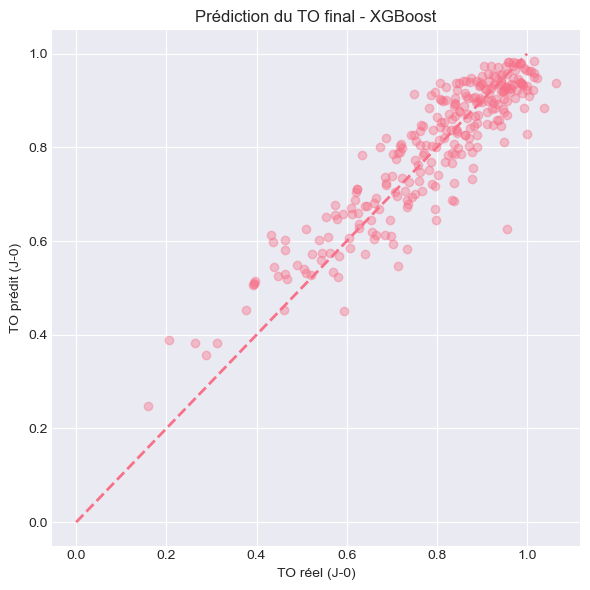

In [113]:
# Scatter réel vs prédit
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.4)
plt.plot([0, 1], [0, 1], "--", linewidth=2)
plt.xlabel("TO réel (J-0)")
plt.ylabel("TO prédit (J-0)")
plt.title("Prédiction du TO final - XGBoost")
plt.grid(True)
plt.tight_layout()
plt.show()

In [117]:
# -----------------------------
# 8. Importance des features
# -----------------------------
importances = model.feature_importances_
feat_importance = pd.DataFrame({
    "feature": feature_cols,
    "importance": importances
}).sort_values(by="importance", ascending=False)

print("\n⭐ TOP 20 features les plus importantes :")
print(feat_importance.head(20))


⭐ TOP 20 features les plus importantes :
            feature  importance
52              J-8    0.461634
51              J-9    0.125079
61          cluster    0.083887
37             J-23    0.031045
35             J-25    0.014009
62            month    0.011448
48             J-12    0.010824
57  pm_change_ratio    0.010680
47             J-13    0.008983
36             J-24    0.008924
6              J-54    0.008889
10             J-50    0.008413
23             J-37    0.008125
15             J-45    0.007124
50             J-10    0.007073
45             J-15    0.006414
43             J-17    0.006411
27             J-33    0.006354
17             J-43    0.006025
63        dayofweek    0.005913


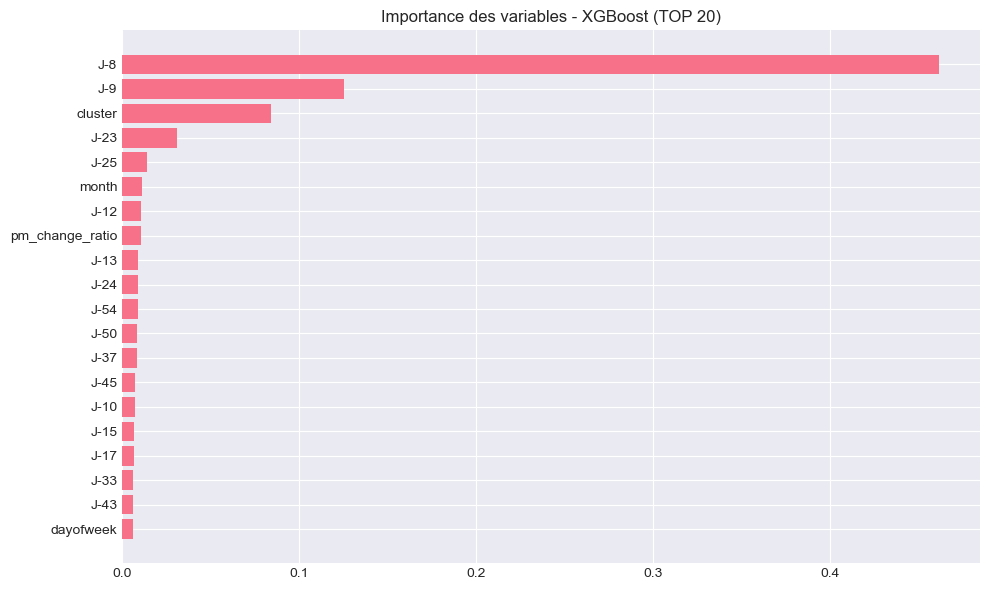

In [118]:
plt.figure(figsize=(10,6))
plt.barh(feat_importance["feature"].head(20), feat_importance["importance"].head(20))
plt.gca().invert_yaxis()
plt.title("Importance des variables - XGBoost (TOP 20)")
plt.tight_layout()
plt.show()

In [ ]:
# -----------------------------
# 9. Sauvegarde modèle + scaler
# -----------------------------
os.makedirs(MODEL_DIR, exist_ok=True)
joblib.dump(model, MODEL_PATH)
joblib.dump(scaler, SCALER_PATH)

print(f"💾 Modèle sauvegardé : {MODEL_PATH}")
print(f"💾 Scaler sauvegardé : {SCALER_PATH}")

In [ ]:
# -----------------------------
# 10. Fonction utilitaire de prédiction (exemple)
# -----------------------------
def predict_to_for_row(row_dict):
    """
    row_dict : dict contenant les même clés que feature_cols
    Exemple de row_dict :
    {
      'J-60': 0.1, 'J-59': 0.12, ..., 'pm_mean': 95.2, 'pm_slope': 0.3,
      'pm_volatility': 2.1, 'nb_observations': 120, 'cluster': 3,
      'month': 8, 'dayofweek': 4
    }
    """
    row_df = pd.DataFrame([row_dict], columns=feature_cols)
    row_scaled = scaler.transform(row_df)
    pred = model.predict(row_scaled)[0]
    return float(pred)




In [120]:
# ------------------------------------------------------------
# 2. Exemple de TO J-60 → J-8 (53 valeurs)
# ------------------------------------------------------------
to_series = [
    0.05, 0.05, 0.06, 0.06, 0.07, 0.07, 0.08, 0.09, 0.10, 0.11,
    0.12, 0.13, 0.15, 0.16, 0.18, 0.20, 0.22, 0.23, 0.25, 0.26,
    0.28, 0.30, 0.31, 0.32, 0.34, 0.35, 0.36, 0.38, 0.40, 0.42,
    0.43, 0.45, 0.46, 0.47, 0.48, 0.50, 0.51, 0.52, 0.53, 0.55,
    0.56, 0.57, 0.58, 0.59, 0.60, 0.62, 0.63, 0.64, 0.65, 0.66,
    0.67, 0.68, 0.69  # J-8
]

# ------------------------------------------------------------
# 3. Exemple de PM J-60 → J-8 (53 valeurs)
# ------------------------------------------------------------
pm_series = [
    120, 121, 120, 119, 118, 118, 119, 120, 121, 121,
    122, 123, 123, 124, 125, 124, 123, 123, 124, 124,
    125, 125, 124, 123, 122, 122, 121, 121, 122, 123,
    124, 125, 125, 126, 126, 127, 126, 125, 125, 126,
    127, 127, 126, 125, 124, 124, 123, 122, 122, 123,
    124, 125, 125   # J-8
]

In [121]:
pm_feats = compute_pm_features(pm_series)

In [ ]:

# ------------------------------------------------------------
# 5. CONSTRUCTION DU row_dict (SANS ERREURS)
# ------------------------------------------------------------
row_dict = {}

# (1) Ajouter TO J-60 → J-8
index_val = 60
for v in to_series:
    row_dict[f"J-{index_val}"] = v
    index_val -= 1

# (2) Add PM features compressées
row_dict.update(pm_feats)

# (3) Variables additionnelles
row_dict["nb_observations"] = len(to_series)   # ici = 53
row_dict["cluster"] = 3
row_dict["month"] = 8
row_dict["dayofweek"] = 4

# ------------------------------------------------------------
# 6. Charger la liste officielle des features apprises
# ------------------------------------------------------------
# ⚠️ Important : XGBoost attend EXACTEMENT les colonnes utilisées à l'entraînement

feature_cols = model.get_booster().feature_names